In [1]:
import gymnasium as gym
import pygame
import numpy as np
import matplotlib.pyplot as plt
import itertools

from agent_class import make_agent

# Initialize environment and agent

In [3]:
# We first create the environment on which we will later train the agent
env = gym.make('LunarLander-v2')

# We need to know the dimensionality of the state space, as well as how many
# actions are possible
N_actions = env.action_space.n
observation, info = env.reset()
N_state = len(observation)

print('dimension of state space =',N_state)
print('number of actions =',N_actions)

dimension of state space = 8
number of actions = 4


In [4]:
# We create an instance of the agent class. 
# At initialization, we need to provide 
# - the dimensionality of the state space, as well as 
# - the number of possible actions
pwams = """
{
    "type": "dqn",
    "n_state": 8,
    "n_actions": 4,
    "layers": [
        8,
        128,
        64,
        32,
        4
    ],
    "dropout": 0.5,
    "n_memory": 20000,
    "training_stride": 10,
    "batch_size": 32,
    "saving_stride": 500,
    "n_episodes_max": 20000,
    "n_solving_episodes": 100,
    "solving_threshold_min": 250,
    "solving_threshold_mean": 270,
    "discount_factor": 0.995,
    "neural_networks": {
        "policy_net": {
            "layers": [
                8,
                128,
                64,
                32,
                4
            ]
        },
        "target_net": {
            "layers": [
                8,
                128,
                64,
                32,
                4
            ]
        }
    },
    "optimizers": {
        "policy_net": {
            "optimizer": "AdamW",
            "optimizer_args": {
                "lr": 0.001
            }
        }
    },
    "losses": {
        "policy_net": {
            "loss": "MSELoss"
        }
    },
    "target_net_update_stride": 1,
    "target_net_update_tau": 0.01,
    "epsilon": 1.0,
    "epsilon_1": 0.1,
    "d_epsilon": 5e-05
}
"""
import json
parameters = json.loads(pwams)

# my_agent = agent.dqn(parameters=parameters)
# to train via the actor-critic algorithm, use this line:
my_agent = make_agent(parameters=parameters)

# Train agent

In [5]:
# We train the agent on the LunarLander-v2 environment.
# Setting verbose=True allows us to follow the progress of the training

training_results = my_agent.train(environment=env,
                                verbose=True,
                                 model_filename="agent-dqn.pt")

| episode | return          | minimal return      | mean return        |
|         | (this episode)  | (last 20 episodes)  | (last 20 episodes) |
|-----------------------------------------------------------------------
{'affinities_regularization': 0.01,    0.000      |         0.000      |
 'batch_size': 32,
 'discount_factor': 0.99,
 'losses': {'policy_net': {'loss': 'MSELoss'}},
 'n_actions': 4,
 'n_episodes_max': 10000,
 'n_memory': 20000,
 'n_solving_episodes': 20,
 'n_state': 8,
 'neural_networks': {'critic_net': {'layers': [8, 64, 32, 1]},
                     'policy_net': {'layers': [8, 128, 32, 4]}},
 'optimizers': {'critic_net': {'optimizer': 'AdamW',
                               'optimizer_args': {'lr': 0.001}},
                'policy_net': {'optimizer': 'AdamW',
                               'optimizer_args': {'lr': 0.001}}},
 'saving_stride': 100,
 'solving_threshold_mean': 230,
 'solving_threshold_min': 200,
 'training_stride': 5,
 'type': 'dqn'}


TypeError: Object of type int64 is not JSON serializable

In [6]:
# the method my_agent.train() from the previous cell returns a dictionary
# with training stats, namely:
# - duration of each episode during training,
# - return of each episode during training
# - the total number of training epochs at the end of each episode
# - the total number of steps simulated at the end of each episode

training_results.keys()

dict_keys(['episode_durations', 'epsiode_returns', 'n_training_epochs', 'n_steps_simulated', 'training_completed'])

# Plot training stats

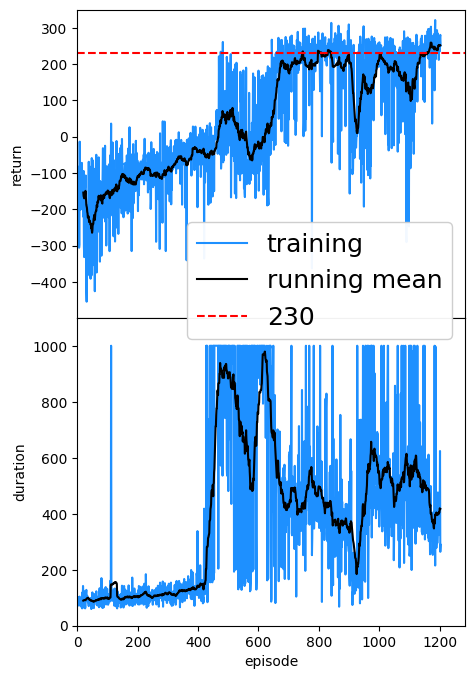

In [7]:
# Plot both the return per episode and the duration per episode during
# training, together with their running average over 20 consecutive episodes

N = 20 # number of episodes for running average

def running_mean(x,N=20):
        x_out = np.zeros(len(x)-N,dtype=float)
        for i in range(len(x)-N):
                x_out[i] = np.mean(x[i:i+N+1])
        return x_out
        
def plot_returns_and_durations(training_results,filename=None):
    fig,axes = plt.subplots(2,1,figsize=(5,8))
    fig.subplots_adjust(hspace=0.0001)
    #
    # return as a function of episode
    ax = axes[0]
    x = training_results['epsiode_returns']
    t = np.arange(len(x)) + 1
    #
    ax.plot(t,x,label='training',color='dodgerblue',)
    # add running mean
    x = running_mean(x=x,N=N)
    t = np.arange(len(x)) + N
    ax.plot(t,x,color='black',label='running mean')
    #
    ax.axhline(230,ls='--',
               label='230',
                        color='red')
    #
    ax.set_ylim(-499,350)
    ax.set_xticks([])
    ax.set_xlim(0,len(t)+100)
    ax.set_xlabel(r'episode')
    ax.set_ylabel(r'return')
    #
    #
    ax = axes[1]
    x = training_results['episode_durations']
    t = np.arange(len(x)) + 1
    #
    ax.plot(t,x,label='training',color='dodgerblue',)
    # add running mean
    x = running_mean(x=x,N=N)
    t = np.arange(len(x)) + N
    ax.plot(t,x,color='black',label='running mean')
    #
    ax.axhline(1200,ls='--', # draw line outside of plot scale, 
                label='230', # to get the red dotted line into the legend
                        color='red')
    #
    ax.set_ylim(0,1100)
    ax.set_xlim(0,len(t)+100)
    ax.set_xlabel(r'episode')
    ax.set_ylabel(r'duration')
    ax.legend(loc='upper right',bbox_to_anchor=(1.,1.35),
                                framealpha=0.95,
                        fontsize=18)
    #
    plt.show()
    if filename != None:
        fig.savefig(filename,bbox_inches='tight')
    plt.close(fig)

plot_returns_and_durations(training_results=training_results)

# Create gameplay video using trained agent

First we create a "live" video that pops up and shows Lunar Lander gameplay performed by the agent

In [8]:
# There is the issue that the game window freezes when running gym games 
# in jupyter notebooks, see https://github.com/openai/gym/issues/2433
# We here use the fix from that website, which is to use the following
# wrapper class:
class PyGameWrapper(gym.Wrapper):
    def render(self, **kwargs):
        retval = self.env.render( **kwargs)
        for event in pygame.event.get():
            pass
        return retval

In [10]:
# Create a wrapped environment
env = PyGameWrapper(gym.make('LunarLander-v2',render_mode='human'))

N_episodes = 1

result_string = 'Run {0}: duration = {1}, total return = {2:7.3f}'

for j in range(N_episodes):
    state, info = env.reset()

    total_reward = 0
    for i in itertools.count():
        #env.render()

        action = my_agent.act(state)
        state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        total_reward += reward

        if done:
            print(result_string.format(j+1,i+1,total_reward))
            break
    
env.close()

[ 0.007125    1.4075737   0.3536978  -0.08728378 -0.00603031 -0.03715588
  0.          0.        ]
[ 0.01056643  1.4050019   0.34406292 -0.11430419 -0.00595433  0.0015194
  0.          0.        ]
[ 0.01391916  1.4018224   0.33292776 -0.14129877 -0.0036467   0.04615711
  0.          0.        ]
[ 1.7182350e-02  1.3980323e+00  3.2171828e-01 -1.6845134e-01
  9.0561860e-04  9.1054976e-02  0.0000000e+00  0.0000000e+00]
[ 0.02037687  1.3936324   0.31309846 -0.19555895  0.0071824   0.12554732
  0.          0.        ]
[ 0.02350645  1.3886274   0.30495763 -0.22250943  0.01508703  0.15810713
  0.          0.        ]
[ 0.02655773  1.3830156   0.29515818 -0.24953727  0.02495195  0.19731669
  0.          0.        ]
[ 0.02951994  1.3767977   0.283984   -0.27660453  0.03705224  0.24202804
  0.          0.        ]
[ 0.03248167  1.3699815   0.28394824 -0.30328336  0.04915001  0.24197741
  0.          0.        ]
[ 0.03544293  1.3625673   0.28391325 -0.32996285  0.06124625  0.24194677
  0.         

We also create a video file containing 20 games played by the agent

In [13]:
from gymnasium.wrappers.monitoring import video_recorder

env = gym.make('LunarLander-v2', render_mode="rgb_array")
video = video_recorder.VideoRecorder(env, './video.mp4'.format())

N_episodes = 20

result_string = 'Run {0}: duration = {1}, total return = {2:7.3f}'

for j in range(N_episodes):
    state, info = env.reset()

    total_reward = 0
    for i in itertools.count():
        video.capture_frame()

        action = my_agent.act(state)
        state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        total_reward += reward

        if done:
            print(result_string.format(j+1,i+1,total_reward))
            break

video.close()
env.close()

Run 1: duration = 301, total return = 261.450
Run 2: duration = 1000, total return = 140.273
Run 3: duration = 256, total return = 240.510
Run 4: duration = 1000, total return = 140.287
Run 5: duration = 225, total return = 224.063
Run 6: duration = 255, total return = 248.000
Run 7: duration = 240, total return = 227.296
Run 8: duration = 273, total return = 242.628
Run 9: duration = 1000, total return = -99.856
Run 10: duration = 228, total return = 250.840
Run 11: duration = 278, total return = 257.135
Run 12: duration = 276, total return = 266.938
Run 13: duration = 262, total return = 257.996
Run 14: duration = 1000, total return = 139.208
Run 15: duration = 299, total return = 213.680
Run 16: duration = 362, total return = 244.364
Run 17: duration = 260, total return = 272.699
Run 18: duration = 1000, total return = 114.247
Run 19: duration = 279, total return = 257.258
Run 20: duration = 287, total return = 246.689
Moviepy - Building video ./video.mp4.
Moviepy - Writing video ./

/home/asger/.pyenv/versions/dmiai/lib/python3.11/site-packages/gymnasium/wrappers/monitoring/video_recorder.py:178: UserWarning: WARN: Unable to save last video! Did you call close()?
  logger.warn("Unable to save last video! Did you call close()?")


TypeError: must be real number, not NoneType